<a href="https://colab.research.google.com/github/sbylash/23_Shasia-Sasa_ML/blob/main/Uts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nama: Shasia Sasa Salsabyla**

**No. Absen: 23**

# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset [CISIA Webface](https://www.kaggle.com/datasets/ntl0601/casia-webface). Perhatian! Dataset ini cukup besar (2.8Gb) dari 500.000 gambar dan 10.575 subjek (label).

Spesifikasi pengerjaan UTS yang harus dipenuhi adalah:

1. Pelajari tentang CISIA Webface!
2. Dikarenakan data gambar dari CISIA masih dalam 1 direktori besar, Anda perlu melakukan proses split antara data latih dan data uji. Anda dapat melakukan ini secara manual (langsung dari direktori) atau secara logikal dengan listing direktori. (10 poin)
3. Lakukan proses pra pengolahan data. Anda wajib dapat menjelaskan proses pra pengolahan data yang dilakukan. (20 poin)
4. Lakukan proses ekstraksi fitur. Fitur yang digunakan bebas. Anda wajib dapat menjelaskan fitur yang digunakan (30 poin)
5. Buat model NN dengan arsitektur yang kelompok Anda rancang sendiri. Model arsitektur bebas (jumlah layer, jumlah node, fungsi aktivasi). (30 poin)
6. Evaluasi performa model NN kelompok Anda dengan metrik akurasi, *precision*, *recall*, dan *F1-Score*. Jelaskan maksud dari metrik-metrik tersebut!


---

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis. Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

# Preparation

In [ ]:
# Load required library
# Import Required Library

from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

# Load Data

Path to dataset files: /root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1


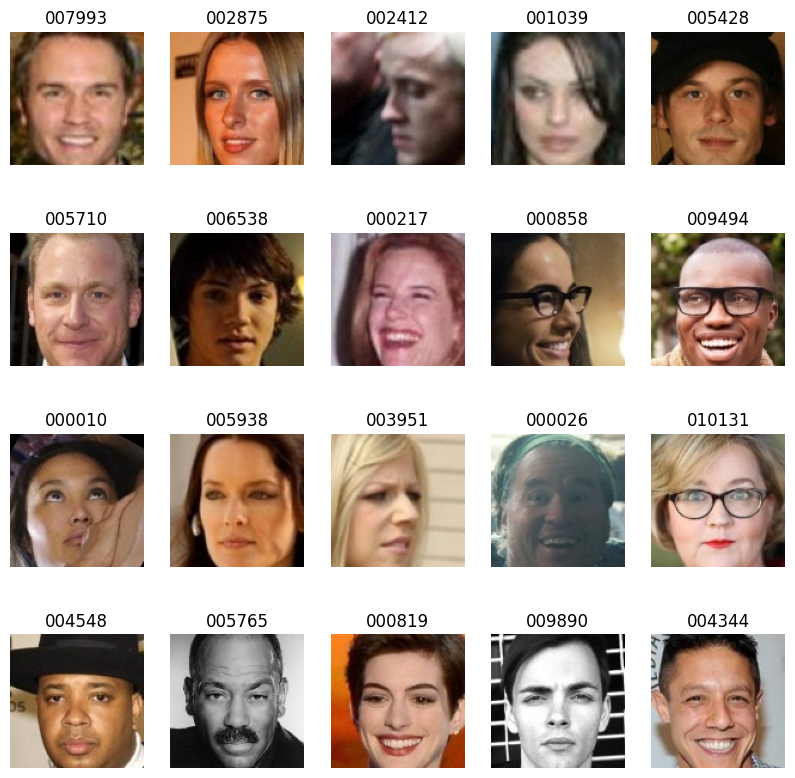

In [3]:
# Bagian ini dapat Anda gunakan untuk melakukan proses loading data dan juga proses split antara data latih dan data uji berdasarkan direktori gambar

import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("ntl0601/casia-webface")

print("Path to dataset files:", dataset_path)

# Ambil path gambar dan label
image_paths = [os.path.join(root, file)
               for root, _, files in os.walk(dataset_path)
               for file in files]
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Visualisasi gambar
def show_sample_images(image_paths, labels, num_samples=20):
    plt.figure(figsize=(10, 10))
    sampled_indices = random.sample(range(len(image_paths)), num_samples)
    for i, idx in enumerate(sampled_indices):
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(4, 5, i+1)
        plt.imshow(img)
        plt.title(labels[idx])
        plt.axis('off')
    plt.show()

# Menampilkan 20 gambar random
show_sample_images(image_paths, labels)

# Preprocessing

In [4]:
'''
Pada bagian ini Anda diperbolehkan untuk melakukan proses pra pengolahan data (preprocessing) sesuai dengan kebutuhan. Pra pengolahan data dapat berupa:

1. Standardisasi nilai fitur ataupun label
2. Penyesuaian ukuran gambar
3. Perubahan colorspace gambar
4. dan lain-lain
'''

# Ambil semua path gambar
image_paths = [os.path.join(root, file)
               for root, _, files in os.walk(dataset_path)
               for file in files]

# Ambil 100 gambar acak
random.seed(42)
sampled_paths = random.sample(image_paths, min(100, len(image_paths)))

# Membuat list gambar dan label
train_img = [(cv2.imread(path), os.path.basename(os.path.dirname(path))) for path in sampled_paths]

# Ubah ukuran gambar
def standarized_input(image):
    return cv2.resize(image, (1100, 600))

# Fungsi preprocessing
def preprocess(img_list):
    std_img_list = []

    for image, label in img_list:
        std_img = standarized_input(image)
        std_img = cv2.cvtColor(std_img, cv2.COLOR_BGR2GRAY)

        # Tambahkan gambar yang diproses dan label asli ke list
        std_img_list.append((std_img, label))

    return std_img_list

# Preprocessing pada gambar yang diambil acak
train_std_img_list = preprocess(train_img)

# Pemeriksaan ukuran gambar yang sudah diproses
pick_random = np.random.randint(0, len(train_std_img_list))
print(f'Image {pick_random}')
print(train_std_img_list[pick_random][0].shape)

Image 84
(600, 1100)


1. **Pengambilan Path Gambar**: Mengambil path semua gambar dalam dataset.
2. **Sampling Acak**: Memilih 100 gambar secara acak untuk mengurangi jumlah data yang diproses.
3. **Ekstraksi Gambar dan Label**: Membaca setiap gambar dan menyimpan labelnya (nama folder).
4. **Penyesuaian Ukuran Gambar**: Mengubah ukuran gambar menjadi 1100x600 piksel.
5. **Konversi Grayscale**: Mengonversi gambar menjadi grayscale untuk mengurangi dimensi data.

Setelah diproses, gambar dan label disimpan dalam list `train_std_img_list` untuk analisis lebih lanjut.

# Features Extraction

In [8]:
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Konversi data dan label ke format yang sesuai
X = np.array([img for img, _ in train_std_img_list])
y = np.array([label for _, label in train_std_img_list])

# Ubah bentuk data menjadi 4D (jumlah gambar, tinggi, lebar, channel)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Konversi label ke format one-hot encoding
y = to_categorical(np.unique(y, return_inverse=True)[1])

# Split data menjadi training dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Membuat model NN
model = Sequential()
model.add(Flatten(input_shape=(600, 1100, 1)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Evaluasi akurasi pada training set
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Train Accuracy: {train_accuracy:.4f}')

# Evaluasi akurasi pada test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1/10
4/4 [==============================] - 3s 668ms/step - loss: 27547.0859 - accuracy: 0.0000e+00 - val_loss: 35147.6953 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 2s 622ms/step - loss: 22138.6699 - accuracy: 0.0000e+00 - val_loss: 20101.8809 - val_accuracy: 0.0625
Epoch 3/10
4/4 [==============================] - 2s 615ms/step - loss: 14587.6699 - accuracy: 0.0000e+00 - val_loss: 11037.7129 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 2s 617ms/step - loss: 6480.9258 - accuracy: 0.0156 - val_loss: 2877.5229 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 3s 634ms/step - loss: 1055.6169 - accuracy: 0.0312 - val_loss: 657.4677 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 2s 627ms/step - loss: 224.3562 - accuracy: 0.0000e+00 - val_loss: 6.7754 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 2s 619ms/step - loss: 28.3749 - accur

Fitur yang digunakan dalam kode ini adalah *pixel intensity values* atau nilai intensitas piksel dari gambar grayscale.

1. **Intensitas Piksel sebagai Fitur**:
   - Gambar dikonversi menjadi grayscale (hitam-putih), sehingga setiap piksel hanya memiliki satu nilai intensitas (0–255), yang menunjukkan tingkat kecerahannya.
   - Setiap piksel ini dijadikan fitur input untuk model neural network.

2. **Pembentukan Data Input**:
   - Data gambar diformat menjadi tensor 4D dengan bentuk `(jumlah gambar, tinggi, lebar, channel)`, yang diperlukan oleh model deep learning untuk mengenali struktur gambar.

3. **One-Hot Encoding pada Label**:
   - Label gambar dikonversi ke format one-hot encoding sehingga cocok untuk klasifikasi multi-kelas.

Fitur intensitas piksel ini memungkinkan model mengenali pola dalam gambar yang relevan untuk klasifikasi.

# Evaluation

In [9]:
'''
Pada bagian ini, lakukan evaluasi terhadap data training dan data testing
'''

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split # Import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split data

# Prediksi pada data testing
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Menghitung metrik evaluasi
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Calculate test accuracy
_, test_accuracy = model.evaluate(X_test, y_test, verbose=0) # Evaluate the model

# Tampilkan hasil metrik
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

1/1 [==============================] - 0s 93ms/step
Test Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Untuk evaluasi performa model neural network, ditambahkan metrik *precision*, *recall*, dan *F1-score* di samping akurasi, agar evaluasi lebih baik. Berikut ini penjelasan dari masing-masing metrik tersebut:

1. **Akurasi**: Proporsi prediksi yang benar dibandingkan dengan seluruh prediksi yang dibuat. Akurasi tinggi menunjukkan bahwa model sering membuat prediksi yang benar secara keseluruhan.

2. **Precision**: Proporsi prediksi positif yang benar terhadap semua prediksi positif. Metrik ini penting untuk kasus di mana kesalahan prediksi positif perlu diminimalisir (mengurangi *false positives*).

3. **Recall**: Proporsi prediksi positif yang benar terhadap semua data yang sebenarnya positif. Metrik ini penting untuk kasus di mana kesalahan dalam mendeteksi positif (missed positives atau *false negatives*) perlu diminimalisir.

4. **F1-Score**: Rata-rata harmonis antara *precision* dan *recall*, memberikan keseimbangan ketika kedua metrik tersebut perlu diperhatikan. F1-score sangat berguna ketika terdapat ketidakseimbangan antara kelas positif dan negatif.

